In [1]:
import skfuzzy as fuzz
import pandas as pd
import numpy as np
import re
df = pd.read_csv('fuzzy_dataset.csv')

In [2]:
def transform_value(value):
    try:
        return int(str(value).rstrip(','))
    except:
        return str(value).rstrip(',')
    
medidas = df\
.groupby(by=['integralizacao'])\
.agg([np.min, np.mean, np.max])\
.transpose()\
.reset_index()\
.applymap(str)\
.apply(lambda x: x + ',')\
.groupby('level_0')\
.apply(lambda x: x.sum())\
.rename(columns=lambda x: transform_value(x))

medidas['level_0'] = medidas['level_0'].apply(lambda x: x.split(',')[0] )
drop = ['id', 'Unnamed: 0']
medidas = medidas[~medidas['level_0'].isin(drop)]


valores = df\
.applymap(str)\
.apply(lambda x: x + ',')\
.groupby(by=['integralizacao'])\
.agg([np.sum])\
.transpose()\
.reset_index()\
.rename(columns=lambda x: transform_value(x))

valores = valores[~valores['level_0'].isin(drop)]

def gen_dict(table):
    table.index = table['level_0']
    table_dict = table\
    .iloc[:, 2:]\
    .to_dict()
    
    for key in table_dict.keys():
        inner_dict = table_dict[key]
        for key2 in inner_dict.keys():
            inner_dict[key2] = inner_dict[key2].split(',')
            inner_dict[key2] = [ x for x in inner_dict[key2] if re.match("^(?=.)([+-]?([0-9]*)(\.([0-9]+))?)$", x) is not None ]
            inner_dict[key2] = [ round(float(x), 2) for x in inner_dict[key2] ]
            inner_dict[key2] = sorted(list(set(inner_dict[key2])))
            
    return table_dict

In [3]:
import seaborn as sns

In [4]:
def flatten_dict(df):
    tmp = gen_dict(df)
    rows = []
    for key in sorted(tmp.keys()):
        for key2 in sorted(tmp[key].keys()):
            for value in tmp[key][key2]:
                row = {
                    "integralizacao": key,
                    "campo": key2,
                    "valor": value
                }
                rows.append(row)
    return pd.DataFrame(rows)

dataplot = flatten_dict(valores)
dataplot = dataplot[dataplot['campo'].str.contains('media')]
dataplot = dataplot\
.groupby(by=['integralizacao', 'campo'])\
.agg([np.mean])\
.reset_index()
dataplot.columns = dataplot.columns.get_level_values(0)
dataplot['valor'] = dataplot['valor'].apply(lambda x: 1 if x >= 6.0 else 0)
dataplot.to_csv('medias_por_integralizacao.csv')

In [5]:
import pandas as pd  
import numpy as np
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics

def regressao(df, idx):
    rows = []
    tmp = df[df['integralizacao']==idx].iloc[:, 3:]
    for item in tmp.columns:
        for item2 in tmp.columns:
            if item != item2:
                tmp2 = tmp[[item, item2]].dropna()
                X = tmp2[item].values.reshape(-1, 1)
                y = tmp2[item2].values.reshape(-1, 1)
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
                regressor = LinearRegression()
                regressor.fit(X_train, y_train)
                y_pred = regressor.predict(X_test)
                row = { 'mse' : metrics.mean_absolute_error(y_test, y_pred),
                       'a' : item,
                       'b' : item2 }
                rows.append(row)
    tmp_df = pd.DataFrame(rows).sort_values(by='mse')
    tmp_df['a'] = tmp_df['a'].combine(tmp_df['b'], lambda x,y: x + ',' + y)
    tmp_df = tmp_df[['mse', 'a']]
    tmp_df = tmp_df[tmp_df['mse'] != 0]
    return tmp_df.head(5)

In [6]:
result = regressao(df, 0)
result['integralizacao'] = 0
for item in set(df['integralizacao'].values):
    if item != 0:
        tmp = regressao(df, item)
        tmp['integralizacao'] = item
        result = result.append(tmp)

In [7]:
result['mse'] = result['mse'].round(2)
# Essa é a tabela resultante da regressão linear
result.to_csv('regressao_linear.csv')

In [8]:
tmp_medidas = medidas\
.iloc[:, 2:]\
.reset_index()
tmp_medidas['level_0'] = tmp_medidas['level_0'].apply(lambda x: x.rstrip(','))
tmp_medidas.index = tmp_medidas['level_0']
tmp_medidas = tmp_medidas.drop(columns='level_0')
tmp_medidas = tmp_medidas.to_dict()

for key in tmp_medidas.keys():
    for key2 in tmp_medidas[key]:
        tmp_medidas[key][key2] = [round(float(x), 2) \
                              for x in tmp_medidas[key][key2].split(',')[0:3]]

def get_num(x):
    try:
        tmp = float(x)
        re.match('^(?=.)([+-]?([0-9]*)(\.([0-9]+))?)$', x)
        return round(tmp, 2)
    except:
        return -1
        
tmp_valores = valores.iloc[:, 2:].to_dict()
for key in tmp_valores.keys():
    for key2 in tmp_valores[key]:
        tmp_valores[key][key2] = sorted(list(set([x for x in [ get_num(x) for x \
                                          in tmp_valores[key][key2].split(',')]
                              if x != -1 ])))

pertinencias = {}
for key in tmp_valores.keys():
    pertinencias[key] = {}
    for key2 in tmp_valores[key]:
        pertinencias[key][key2] = None
        
for key in tmp_valores.keys():
    for key2 in tmp_valores[key]:
        try:
            arr = sorted(np.array(tmp_medidas[key][key2]))
        except:
            continue
        bom = \
        [arr[1]] + [arr[2]] + [arr[2]]
        medio = \
        [arr[0]] + [arr[1]] + [arr[2]]
        ruim = \
        [arr[0]] + [arr[0]] + [arr[1]]
        pertinencias[key][key2] = {
            'bom': fuzz.trimf(np.array(tmp_valores[key][key2]), 
                                             np.array(bom)),
            'medio': fuzz.trimf(np.array(tmp_valores[key][key2]), 
                                             np.array(medio)),
            'ruim': fuzz.trimf(np.array(tmp_valores[key][key2]), 
                                             np.array(ruim))
        }

/media/user/DADOS1/anaconda/envs/iainverno/lib/python3.7/site-packages/skfuzzy/membership/generatemf.py:441: RuntimeWarning: invalid value encountered in less
  idx = np.nonzero(np.logical_and(a < x, x < b))[0]
/media/user/DADOS1/anaconda/envs/iainverno/lib/python3.7/site-packages/skfuzzy/membership/generatemf.py:446: RuntimeWarning: invalid value encountered in less
  idx = np.nonzero(np.logical_and(b < x, x < c))[0]


In [9]:
classificacao = {
    "bom": fuzz.trimf(np.arange(0,10,1), [5, 10, 10]),
    "medio": fuzz.trimf(np.arange(0,10,1), [0, 5, 10]),
    "ruim": fuzz.trimf(np.arange(0,10,1), [0, 0, 5])
}

In [10]:
def get_user_data(df, idx):
    tmp = df[df['id']==idx]
    tmp = tmp\
    .iloc[:, 2:]
    tmp.index = tmp['integralizacao']
    tmp = tmp.drop(columns='integralizacao')
    return tmp.transpose().to_dict()

In [14]:
def activate(user, tmp_valores, pertinencias):
    ativacao = {}
    for key in tmp_valores.keys():
        ativacao[key] = {}
        for key2 in tmp_valores[key]:
            ativacao[key][key2] = {}
    
    for key in tmp_valores.keys():
        for key2 in tmp_valores[key]:
            try:
                value = user[key][key2]
                universe = tmp_valores[key][key2]
                for key3 in pertinencias[key][key2]:
                    ativacao[key][key2][key3] = \
                    fuzz.interp_membership(universe, 
                                           pertinencias[key][key2][key3],
                                           value)
            except:
                continue
    return ativacao

**REGRAS**

* 0  

baixo media_programacao, baixo media_NC -> mau aluno  
media media_programacao, media media_NC -> medio aluno  
alto media_programacao, alto media_NC -> bom aluno  

* 1    

alto reprovacoes_NC, alto reprovacoes_matematica -> mau aluno  
medio reprovacoes_NC e medio quantidade_trancamento -> medio aluno  
baixo reprovacoes_NC, baixo reprovacoes_matematica -> mau aluno  

* 2   

baixo media_NC e baixo media_programacao -> mau aluno  
medio reprovacoes_programacao e medio quantidade_trancamento -> medio aluno  
alto media_NC e alto media_programacao -> bom aluno  

* 3   

baixo media_NC e baixo media_programacao -> mau aluno  
medio media_matematica e medio quantidade_trancamento -> medio aluno  
alto media_NC e alto media_programacao -> bom aluno  


* 4    

alto media_NE e alto media_programacao -> bom aluno  
medio media_NE e medio quantidade_trancamento -> medio aluno  
baixo media_NE e baixo media_programacao -> mau aluno  

* 5   

alto media_NE e alto media_programacao -> bom aluno   
medio reprovacoes_matematica e medio quantidade_trancamento -> medio aluno  
baixo media_NE e baixo media_programacao -> mau aluno  


* 6   

baixo reprovacoes_NC e baixo quantidade_trancamentos -> bom aluno  
medio reprovacoes_NC e medio quantidade_trancamentos -> medio aluno  
alto reprovacoes_NC e alto quantidade_trancamentos -> mau aluno  


* 7    

baixo reprovacoes_NE e baixo quantidade_trancamentos -> bom aluno  
medio reprovacoes_NE e medio quantidade_trancamentos -> medio aluno  
alto reprovacoes_NE e alto quantidade_trancamentos -> mau aluno  


* 8    

baixo reprovacoes_matematica e baixo quantidade_trancamentos -> bom aluno  
medio reprovacoes_matematica e medio quantidade_trancamentos -> medio aluno  
alto reprovacoes_matematica e alto quantidade_trancamentos -> mau aluno  

* 9    

baixo reprovacoes_NE e baixo reprovacoes_programacao -> bom aluno  
medio reprovacoes_NE e medio reprovacoes_programacao -> medio aluno  
alto reprovacoes_NE e alto reprovacoes_programacao -> mau aluno  


* 10    

baixo reprovacoes_NC e baixo reprovacoes_programacao -> bom aluno  
medio reprovacoes_NC e medio reprovacoes_programacao -> medio aluno  
alto reprovacoes_NC e alto reprovacoes_programacao -> mau aluno   


In [28]:
ativacoes = activate(get_user_data(df, 30), 
                     tmp_valores, 
                     pertinencias)

def classify(ativacoes):
    result = {}
    try:
        # 0
        # baixo media_programacao OU baixo media_NC -> mau aluno
        # media media_programacao E media media_NC -> medio aluno
        # alto media_programacao E alto media_NC -> bom aluno
        a = ativacoes[0]['media_programacao']['ruim']
        b = ativacoes[0]['media_NC']['ruim']
        c = classificacao['ruim']
        ruim = np.fmin(np.fmax(a,b), c)
        a = ativacoes[0]['media_programacao']['medio']
        b = ativacoes[0]['media_NC']['medio']
        c = classificacao['medio']
        medio = np.fmin(np.fmin(a,b), c)
        a = ativacoes[0]['media_programacao']['bom']
        b = ativacoes[0]['media_NC']['bom']
        c = classificacao['bom']
        bom = np.fmin(np.fmin(a,b), c)

        agg = np.fmax(ruim,
                         np.fmax(medio, bom))
        result[0] = fuzz.defuzz(np.arange(0,10,1), agg, 'centroid')
    except:
        pass

    try:
        # 1
        # alto reprovacoes_NC OU alto reprovacoes_matematica -> mau aluno
        # medio reprovacoes_NC E medio quantidade_trancamento -> medio aluno
        # baixo reprovacoes_NC E baixo reprovacoes_matematica -> bom aluno
        a = ativacoes[1]['reprovacoes_NC']['bom']
        b = ativacoes[1]['reprovacoes_matematica']['bom']
        c = classificacao['ruim']
        ruim = np.fmin(np.fmax(a,b), c)
        a = ativacoes[1]['reprovacoes_NC']['medio']
        b = ativacoes[1]['reprovacoes_matematica']['medio']
        c = classificacao['medio']
        medio = np.fmin(np.fmin(a,b), c)
        a = ativacoes[1]['reprovacoes_NC']['ruim']
        b = ativacoes[1]['reprovacoes_matematica']['ruim']
        c = classificacao['bom']
        bom = np.fmin(np.fmin(a,b), c)

        agg = np.fmax(ruim,
                         np.fmax(medio, bom))
        result[1] = fuzz.defuzz(np.arange(0,10,1), agg, 'centroid')
    except:
        pass

    try:
        # 2
        # baixo media_NC e baixo media_programacao -> mau aluno
        # medio reprovacoes_programacao e medio quantidade_trancamento -> medio aluno
        # alto media_NC e alto media_programacao -> bom aluno
        a = ativacoes[2]['media_NC']['ruim']
        b = ativacoes[2]['media_programacao']['ruim']
        c = classificacao['ruim']
        ruim = np.fmin(np.fmin(a,b), c)
        a = ativacoes[2]['reprovacoes_programacao']['medio']
        b = ativacoes[2]['quantidade_trancamentos']['medio']
        c = classificacao['medio']
        medio = np.fmin(np.fmin(a,b), c)
        a = ativacoes[2]['media_NC']['bom']
        b = ativacoes[2]['media_programacao']['bom']
        c = classificacao['bom']
        bom = np.fmin(np.fmin(a,b), c)

        agg = np.fmax(ruim,
                         np.fmax(medio, bom))
        result[2] = fuzz.defuzz(np.arange(0,10,1), agg, 'centroid')
    except:
        pass
    
    try:
        # 3
        # baixo media_NC e baixo media_programacao -> mau aluno
        # medio media_matematica e medio quantidade_trancamento -> medio aluno
        # alto media_NC e alto media_programacao -> bom aluno
        a = ativacoes[3]['media_NC']['ruim']
        b = ativacoes[3]['media_programacao']['ruim']
        c = classificacao['ruim']
        ruim = np.fmin(np.fmin(a,b), c)
        a = ativacoes[3]['media_matematica']['medio']
        b = ativacoes[3]['quantidade_trancamentos']['medio']
        c = classificacao['medio']
        medio = np.fmin(np.fmin(a,b), c)
        a = ativacoes[3]['media_NC']['bom']
        b = ativacoes[3]['media_programacao']['bom']
        c = classificacao['bom']
        bom = np.fmin(np.fmin(a,b), c)

        agg = np.fmax(ruim,
                         np.fmax(medio, bom))
        result[3] = fuzz.defuzz(np.arange(0,10,1), agg, 'centroid')
    except:
        pass
    
    try:
        # 4
        # alto media_NE e alto media_programacao -> bom aluno
        # medio media_NE e medio quantidade_trancamento -> medio aluno
        # baixo media_NE e baixo media_programacao -> mau aluno
        a = ativacoes[4]['media_NE']['ruim']
        b = ativacoes[4]['media_programacao']['ruim']
        c = classificacao['ruim']
        ruim = np.fmin(np.fmin(a,b), c)
        a = ativacoes[4]['media_NE']['medio']
        b = ativacoes[4]['quantidade_trancamentos']['medio']
        c = classificacao['medio']
        medio = np.fmin(np.fmin(a,b), c)
        a = ativacoes[4]['media_NE']['bom']
        b = ativacoes[4]['media_programacao']['bom']
        c = classificacao['bom']
        bom = np.fmin(np.fmin(a,b), c)

        agg = np.fmax(ruim,
                         np.fmax(medio, bom))
        result[4] = fuzz.defuzz(np.arange(0,10,1), agg, 'centroid')
    except:
        pass
    
    try:
        # 5
        # alto media_NE e alto media_programacao -> bom aluno
        # medio reprovacoes_matematica e medio quantidade_trancamento -> medio aluno
        # baixo media_NE e baixo media_programacao -> mau aluno
        a = ativacoes[5]['media_NE']['ruim']
        b = ativacoes[5]['media_programacao']['ruim']
        c = classificacao['ruim']
        ruim = np.fmin(np.fmin(a,b), c)
        a = ativacoes[5]['reprovacoes_matematica']['medio']
        b = ativacoes[5]['quantidade_trancamentos']['medio']
        c = classificacao['medio']
        medio = np.fmin(np.fmin(a,b), c)
        a = ativacoes[5]['media_NE']['bom']
        b = ativacoes[5]['media_programacao']['bom']
        c = classificacao['bom']
        bom = np.fmin(np.fmin(a,b), c)

        agg = np.fmax(ruim,
                         np.fmax(medio, bom))
        result[5] = fuzz.defuzz(np.arange(0,10,1), agg, 'centroid')
    except:
        pass
    
    try:
        # 6
        # baixo reprovacoes_NC e baixo quantidade_trancamentos -> bom aluno
        # medio reprovacoes_NC e medio quantidade_trancamentos -> medio aluno
        # alto reprovacoes_NC e alto quantidade_trancamentos -> mau aluno
        a = ativacoes[6]['reprovacoes_NC']['bom']
        b = ativacoes[6]['quantidade_trancamentos']['bom']
        c = classificacao['ruim']
        ruim = np.fmin(np.fmin(a,b), c)
        a = ativacoes[6]['reprovacoes_NC']['medio']
        b = ativacoes[6]['quantidade_trancamentos']['medio']
        c = classificacao['medio']
        medio = np.fmin(np.fmin(a,b), c)
        a = ativacoes[6]['reprovacoes_NC']['ruim']
        b = ativacoes[6]['quantidade_trancamentos']['ruim']
        c = classificacao['bom']
        bom = np.fmin(np.fmin(a,b), c)

        agg = np.fmax(ruim,
                         np.fmax(medio, bom))
        result[6] = fuzz.defuzz(np.arange(0,10,1), agg, 'centroid')
    except:
        pass
    
    
    try:
        # 7
        # baixo reprovacoes_NE e baixo quantidade_trancamentos -> bom aluno
        # medio reprovacoes_NE e medio quantidade_trancamentos -> medio aluno
        # alto reprovacoes_NE e alto quantidade_trancamentos -> mau aluno
        a = ativacoes[7]['reprovacoes_NE']['bom']
        b = ativacoes[7]['quantidade_trancamentos']['bom']
        c = classificacao['ruim']
        ruim = np.fmin(np.fmin(a,b), c)
        a = ativacoes[7]['reprovacoes_NE']['medio']
        b = ativacoes[7]['quantidade_trancamentos']['medio']
        c = classificacao['medio']
        medio = np.fmin(np.fmin(a,b), c)
        a = ativacoes[7]['reprovacoes_NE']['ruim']
        b = ativacoes[7]['quantidade_trancamentos']['ruim']
        c = classificacao['bom']
        bom = np.fmin(np.fmin(a,b), c)

        agg = np.fmax(ruim,
                         np.fmax(medio, bom))
        result[7] = fuzz.defuzz(np.arange(0,10,1), agg, 'centroid')
    except:
        pass

    try:
        # 8
        # baixo reprovacoes_matematica e baixo quantidade_trancamentos -> bom aluno
        # medio reprovacoes_matematica e medio quantidade_trancamentos -> medio aluno
        # alto reprovacoes_matematica e alto quantidade_trancamentos -> mau aluno
        a = ativacoes[8]['reprovacoes_matematica']['bom']
        b = ativacoes[8]['quantidade_trancamentos']['bom']
        c = classificacao['ruim']
        ruim = np.fmin(np.fmin(a,b), c)
        a = ativacoes[8]['reprovacoes_matematica']['medio']
        b = ativacoes[8]['quantidade_trancamentos']['medio']
        c = classificacao['medio']
        medio = np.fmin(np.fmin(a,b), c)
        a = ativacoes[8]['reprovacoes_matematica']['ruim']
        b = ativacoes[8]['quantidade_trancamentos']['ruim']
        c = classificacao['bom']
        bom = np.fmin(np.fmin(a,b), c)

        agg = np.fmax(ruim,
                         np.fmax(medio, bom))
        result[8] = fuzz.defuzz(np.arange(0,10,1), agg, 'centroid')
    except:
        pass
    
    try:
        # 9
        # baixo reprovacoes_NE e baixo reprovacoes_programacao -> bom aluno
        # medio reprovacoes_NE e medio reprovacoes_programacao -> medio aluno
        # alto reprovacoes_NE e alto reprovacoes_programacao -> mau aluno
        a = ativacoes[9]['reprovacoes_NE']['bom']
        b = ativacoes[9]['reprovacoes_programacao']['bom']
        c = classificacao['ruim']
        ruim = np.fmin(np.fmin(a,b), c)
        a = ativacoes[9]['reprovacoes_NE']['medio']
        b = ativacoes[9]['reprovacoes_programacao']['medio']
        c = classificacao['medio']
        medio = np.fmin(np.fmin(a,b), c)
        a = ativacoes[9]['reprovacoes_NE']['ruim']
        b = ativacoes[9]['reprovacoes_programacao']['ruim']
        c = classificacao['bom']
        bom = np.fmin(np.fmin(a,b), c)

        agg = np.fmax(ruim,
                         np.fmax(medio, bom))
        result[9] = fuzz.defuzz(np.arange(0,10,1), agg, 'centroid')
    except:
        pass

    try:
        # 10
        # baixo reprovacoes_NC e baixo reprovacoes_programacao -> bom aluno
        # medio reprovacoes_NC e medio reprovacoes_programacao -> medio aluno
        # alto reprovacoes_NC e alto reprovacoes_programacao -> mau aluno
        a = ativacoes[10]['reprovacoes_NC']['bom']
        b = ativacoes[10]['reprovacoes_programacao']['bom']
        c = classificacao['ruim']
        ruim = np.fmin(np.fmin(a,b), c)
        a = ativacoes[10]['reprovacoes_NC']['medio']
        b = ativacoes[10]['reprovacoes_programacao']['medio']
        c = classificacao['medio']
        medio = np.fmin(np.fmin(a,b), c)
        a = ativacoes[10]['reprovacoes_NC']['ruim']
        b = ativacoes[10]['reprovacoes_programacao']['ruim']
        c = classificacao['bom']
        bom = np.fmin(np.fmin(a,b), c)

        agg = np.fmax(ruim,
                         np.fmax(medio, bom))
        result[10] = fuzz.defuzz(np.arange(0,10,1), agg, 'centroid')
    except:
        pass
    return result

classify(ativacoes)

{0: 5.137747016162039,
 2: 7.435886182429961,
 3: 7.512727838016401,
 5: 7.258199165175908,
 6: 7.666666666666666,
 9: 7.666666666666666}

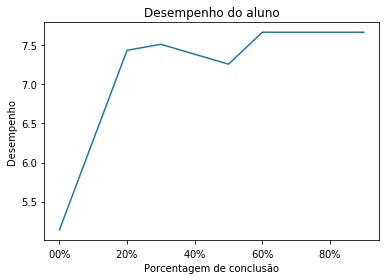

In [50]:
from matplotlib.ticker import FuncFormatter
formatter = FuncFormatter(lambda x_val, tick_pos: "${{{0}}}0\%$".format(int(x_val)))

def plot_classification(result):
    g = sns.lineplot(x=0,
                        y=1,
                        data=pd.DataFrame(sorted(result.items(), key=lambda x: x[0])))
    g.xaxis.set_major_formatter(formatter)
    g.set_title('Desempenho do aluno')
    g.set(ylabel='Desempenho')
    g.set(xlabel='Porcentagem de conclusão')

plot_classification(classify(ativacoes))